Il clustering è stato valutato secondo quando scritto in questo paper: Recommendations for validating hierarchical clustering in consumer sensory projects

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import seaborn as sns

**Pulizia del dataset che interessa questo clustering**

In [2]:
def get_prepared_dataset() -> pd.DataFrame:
    df = pd.read_csv('../../data/cluster.csv').reset_index(names='id')
    df['date'] = pd.to_datetime(df['date'])
    df = df[df.state == 'Illinois']
    
    df = df[df.n_participants > 0]
    return df

**Creazione delle features per il clustering**

In [3]:
#Selezione delle colonne utili per il clustering
selected_columns = ['latitude', 'longitude', 'n_participants_child', 'n_participants_teen', 'n_participants_adult', 'avg_age_participants',
                    'n_males', 'n_females', 'n_killed', 'n_arrested', 'n_unharmed', 'n_injured', 'n_participants', 'povertyPercentage']
df = get_prepared_dataset()[selected_columns]

df['n_participants_child_ratio'] = df['n_participants_child'] / df['n_participants']
df['n_participants_teen_ratio'] = df['n_participants_teen'] / df['n_participants']
df['n_participants_adult_ratio'] = df['n_participants_adult'] / df['n_participants']

df['n_males_ratio'] = df['n_males']/df['n_participants']
df['n_females_ratio'] = df['n_females']/df['n_participants']

df['n_arrested_ratio'] = df['n_arrested']/df['n_participants']
df['n_unharmed_ratio'] = df['n_unharmed']/df['n_participants']
df['n_injured_ratio'] = df['n_injured']/df['n_participants']
df['n_killed_ratio'] = df['n_killed']/df['n_participants']

df['poverty_ratio'] = df['povertyPercentage']/100

df['incident_severity'] = (df['n_killed_ratio'] + df['n_injured_ratio'])/df['n_participants']


**Calcolo matrice di correlzione** (ci aiuta a scegliere quali attributi mantenere)

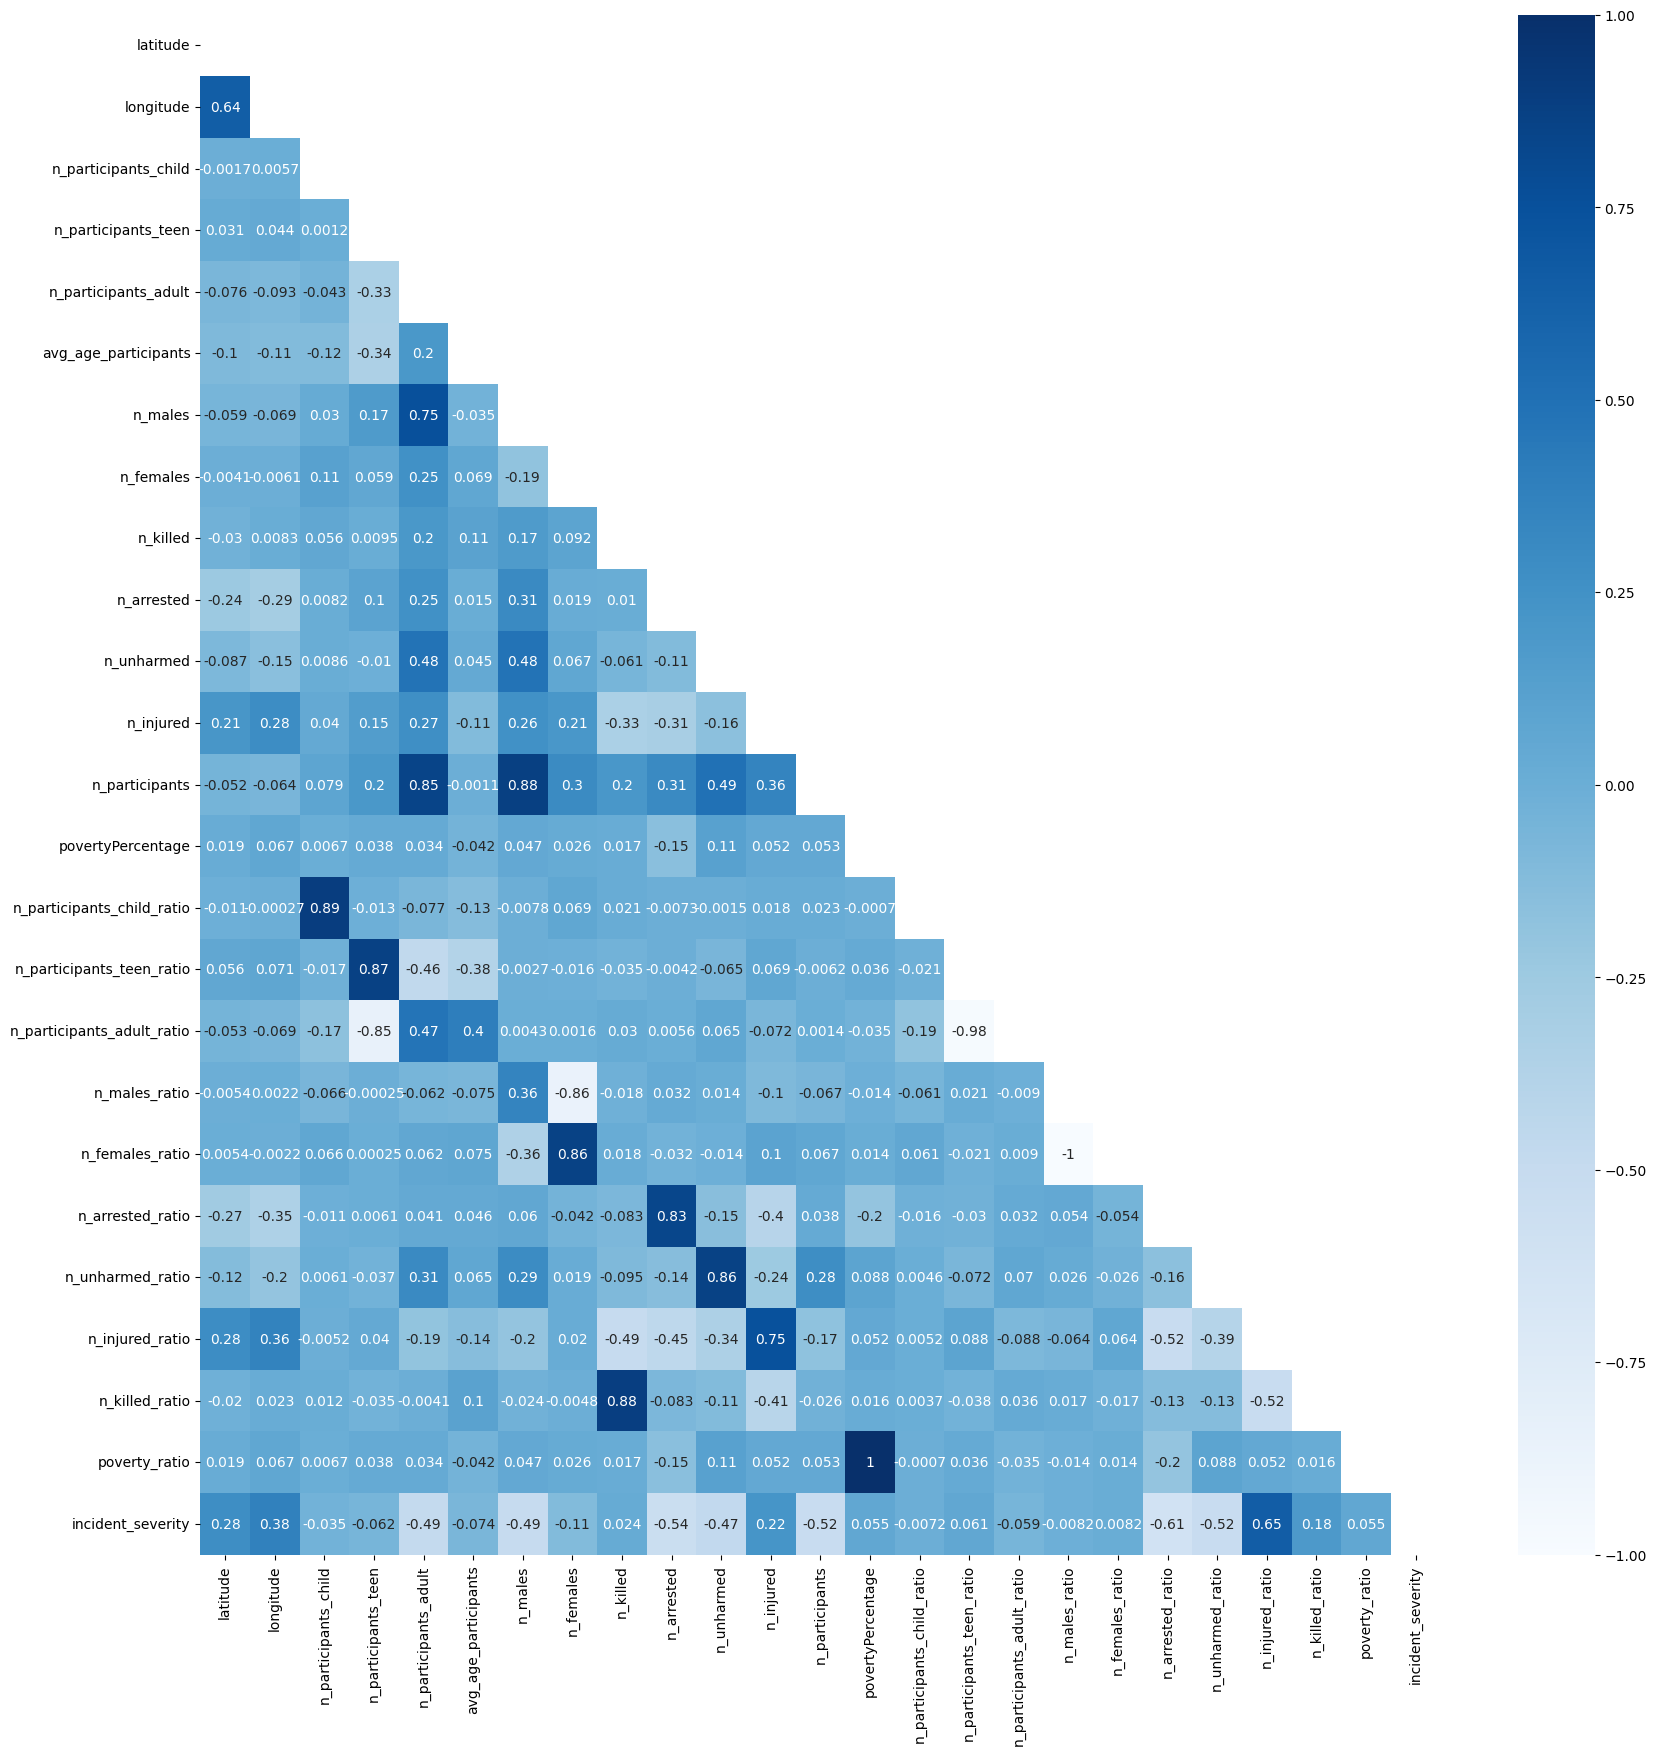

In [4]:
data = df.corr()
mask = np.triu(np.ones_like(data, dtype=bool))

plt.figure(figsize=(20,20))
sns.heatmap(data, annot=True, cmap='Blues', mask=mask)
plt.show()

**Testiamo diverse combinazioni di features per il clustering**

In [5]:
selected_columns1 = pd.Index(['latitude', 'longitude', 'n_participants_child_ratio', 
                            'n_participants_teen_ratio', 'n_participants_adult_ratio', 
                            'n_males_ratio', 'n_females_ratio', 'n_arrested_ratio', 'n_unharmed_ratio',
                            'n_injured_ratio', 'n_killed_ratio', 'poverty_ratio', 'incident_severity', 'n_participants', 'avg_age_participants'])

selected_columns2 = selected_columns1.difference(["latitude", "longitude"])
selected_columns3 = selected_columns1.difference(["latitude", "longitude", "poverty_ratio"])
selected_columns4 = selected_columns1.difference(["latitude", "longitude", "avg_age_participants"])
selected_columns5 = df.columns
selected_columns6 = df.columns.difference(["latitude", "longitude"])

df1 = df[selected_columns1].dropna()
df2 = df[selected_columns2].dropna()
df3 = df[selected_columns3].dropna()
df4 = df[selected_columns4].dropna()
df5 = df[selected_columns5].dropna()
df6 = df[selected_columns6].dropna()

df_list = [df1, df2, df3, df4, df5, df6]

## Clustering Preprocessing - Normalization  
A good practice in clustering to avoid the bias given by the range of the different attribute is normalization.  
The most common adopted normalizations are: Z-Score and Min-Max
* Uso Z-Score perché abbiamo tanti outliers (che vogliamo tenere)

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

cluster_data_list = []
for df in df_list:
    X = scaler.fit_transform(df.values)
    cluster_data_list.append(X)

## Hierarchical clustering


- Min / Single-linkage
    - it tends to perform similarly to DBSCAN
    - is able to recognize non-elliptical clusters
    - is notoriously sensitive to noise and outliers
- Max / Complete-Linkage
    - it is more resistant than the single-linkage to outliers and noise
    - is known for breaking the larger clusters into smaller globular ones 
- Average-linkage
    - it is less susceptible to noise and outliers
    - it tends to prefer globular clusters
- Ward-linkage
    - the hierarchical analogue of K-means 
    - it is a centroid based approach with a particular interest in the minimization of the SSE values associated with each cluster

In [7]:
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering

methods = ['complete', 'single', 'average', 'ward']

**Calcoliamo il cophenetic coefficients per determinare quali features permettono di avere un clustering migliore**

- Dalla tabella si può osservare le features in selected_columns4 con average-link ha il coefficiente maggiore => scegliamo questo clustering.
- Uno dei motivi per cui l'avarage link performa meglio degli altri potrebbe attribursi al fatto che è meno sensibili agli outliers (Ricordiamo che gli outliers NON sono stati rimossi)

In [8]:

def _get_cophenetic_coefficients(X, methods = methods) -> pd.DataFrame:
    """ 
    Calcola i coefficienti cophenetic per i vari metodi di clustering.
    """
    cophenetic_coefficients_df = pd.DataFrame()

    for method in methods:
        Z = linkage(X, method)
        cophenetic_coefficients, _ = cophenet(Z, pdist(X, metric='euclidean'))
        
        cophenetic_coefficients_df[method] = [cophenetic_coefficients]
    
    return cophenetic_coefficients_df

def get_cophenetic_coefficients(cluster_data_list) -> pd.DataFrame:
    cophenetic_coefficients_df = pd.DataFrame()
    for X in cluster_data_list:
        df = _get_cophenetic_coefficients(X)
        cophenetic_coefficients_df = pd.concat([cophenetic_coefficients_df, df], axis=0)

    return cophenetic_coefficients_df

get_cophenetic_coefficients(cluster_data_list)

,complete,single,average,ward
0,0.727312,0.794295,0.882941,0.577481
0,0.709900,0.815978,0.906484,0.616421
0,0.796061,0.838932,0.911274,0.654375
0,0.840924,0.838883,0.918933,0.641166
0,0.769087,0.796771,0.877673,0.565746
0,0.760944,0.800699,0.880865,0.582273


In [9]:
best_X = cluster_data_list[4-1]

**Ploting dendrogram**

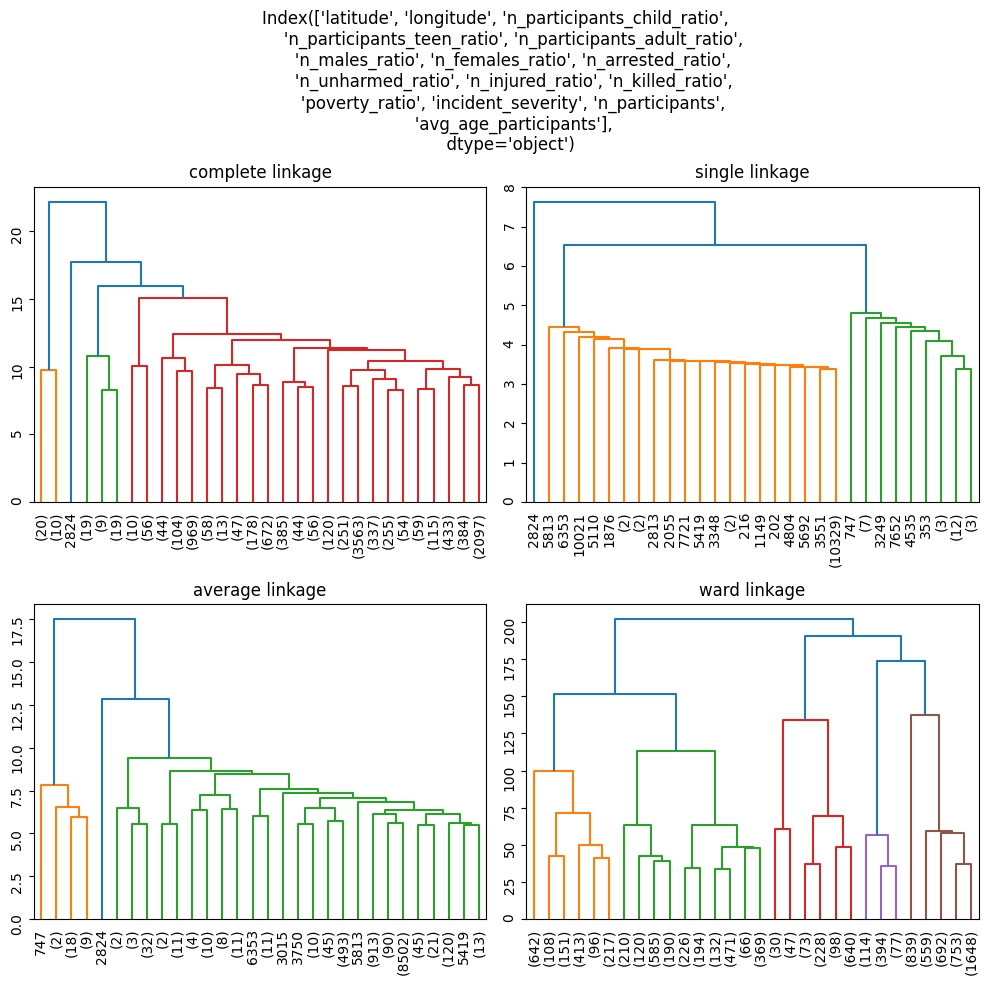

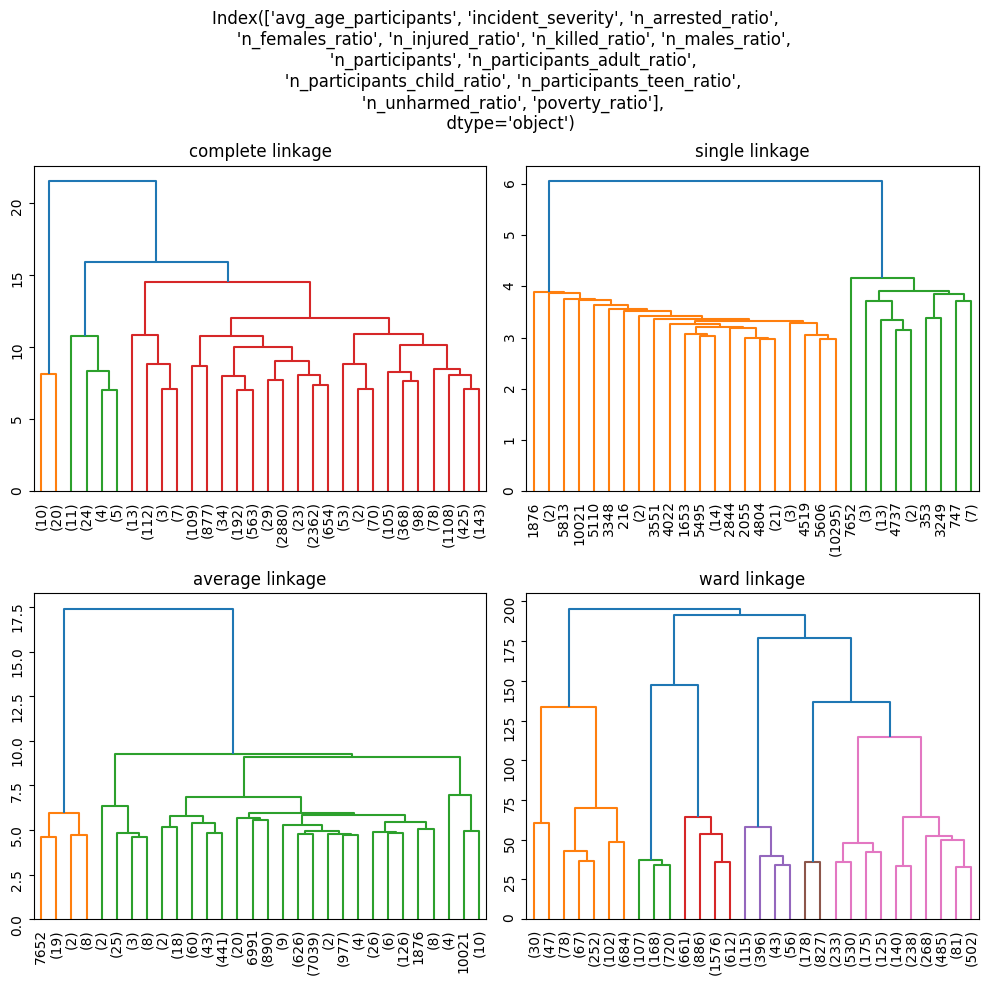

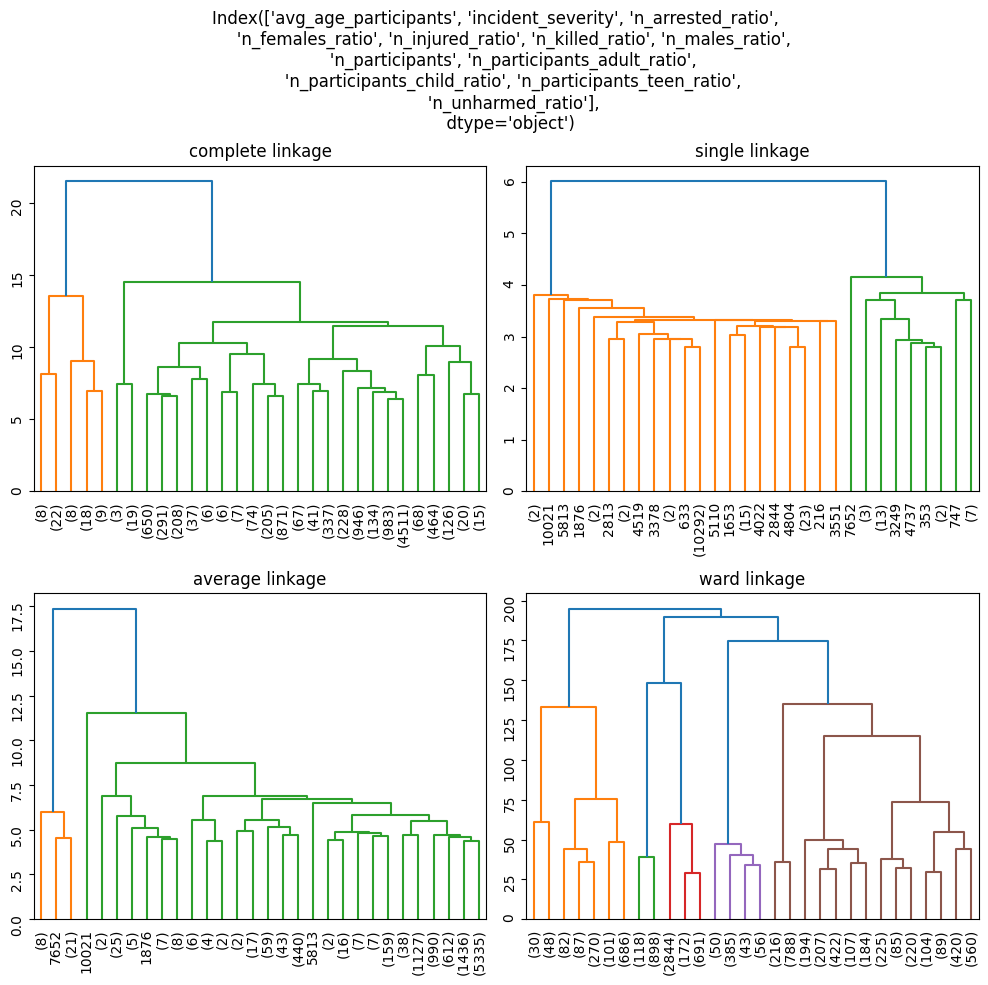

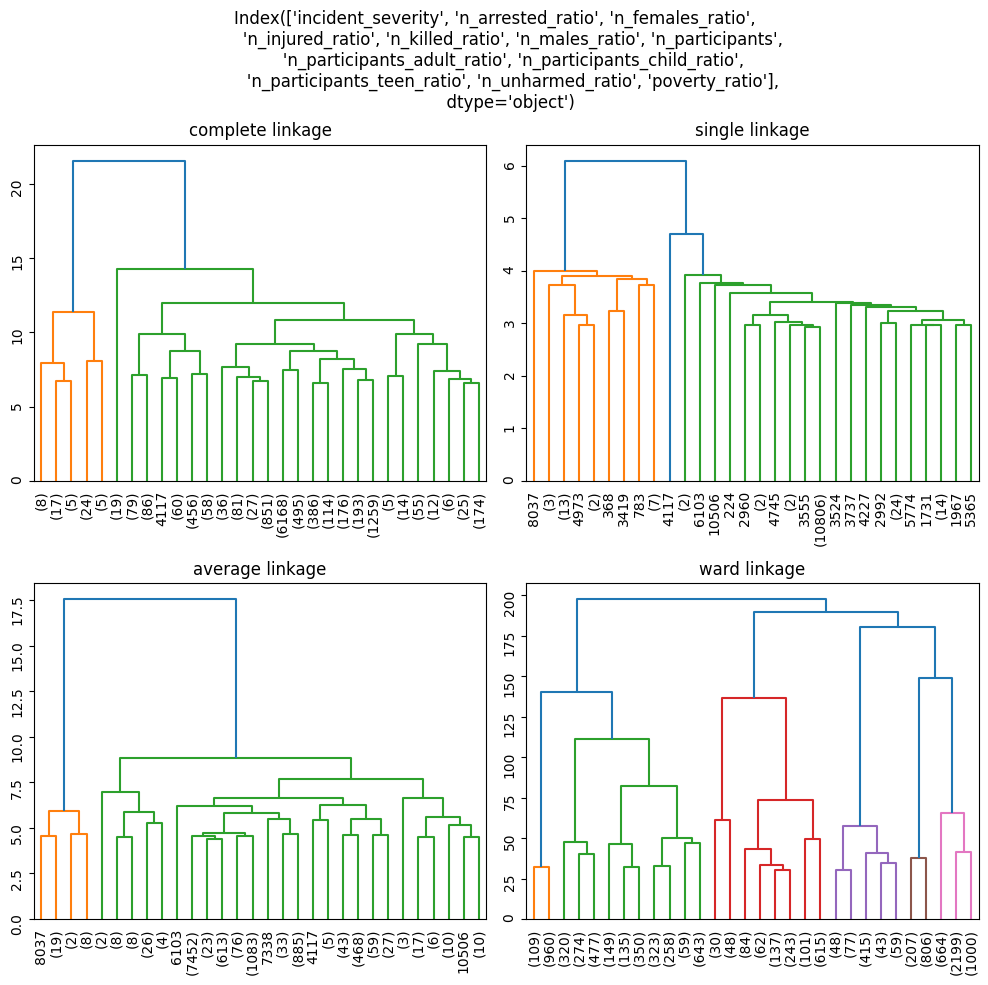

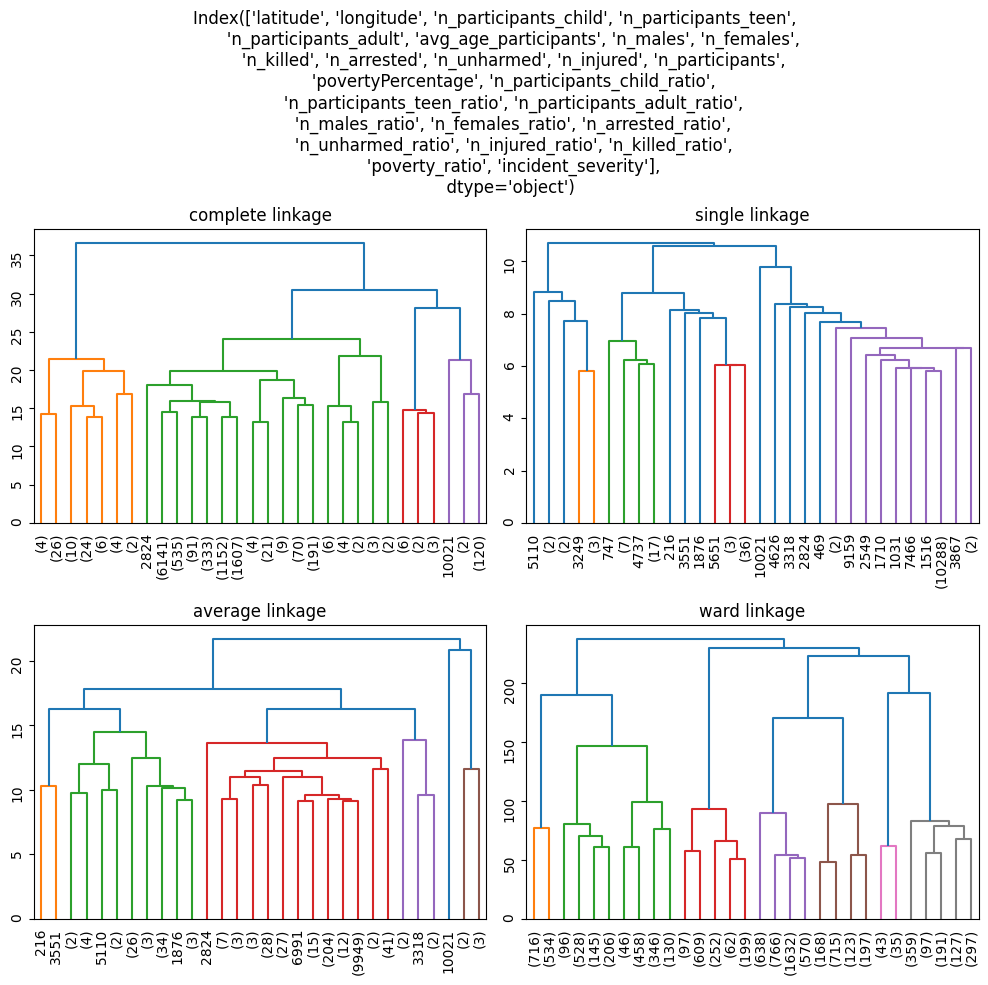

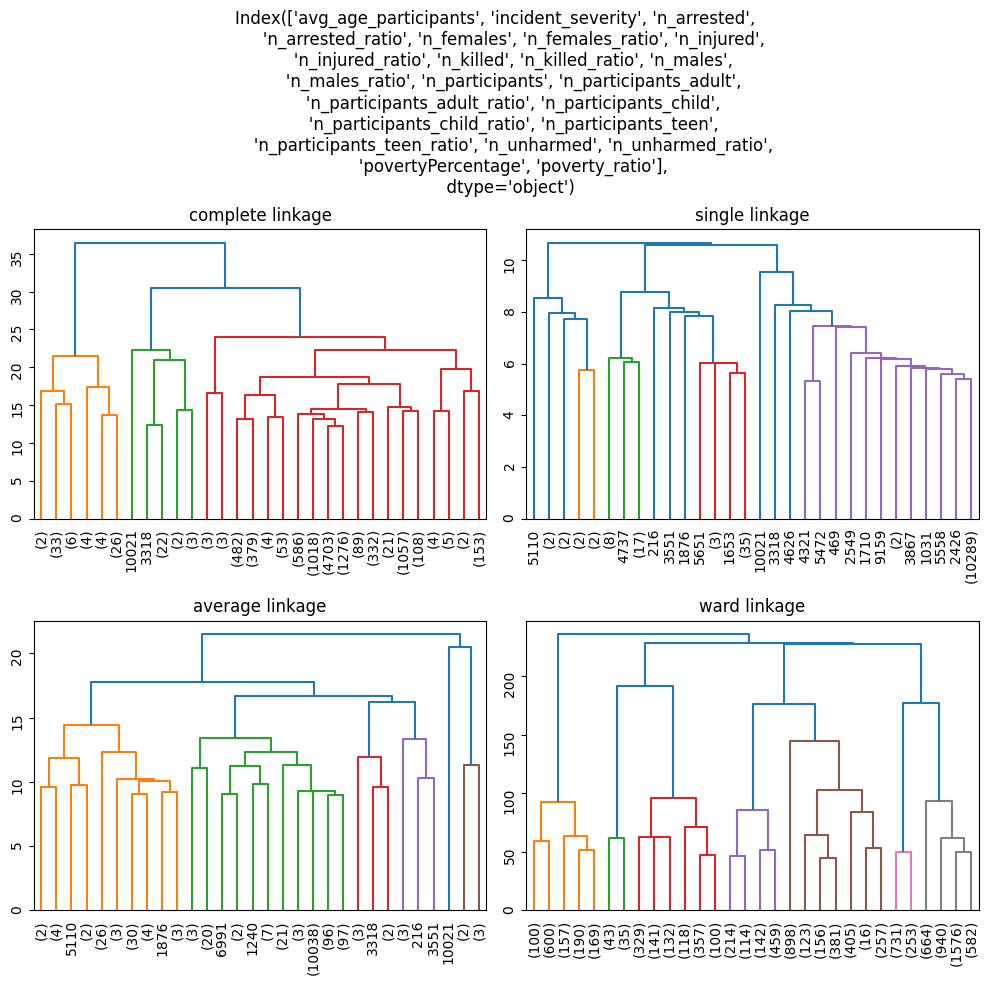

In [10]:
def dendogramPlot(X, methods, title: str):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for ax, method in zip(axs.flatten(), methods):
        data_dist = pdist(X, metric='euclidean')
        data_link = linkage(data_dist, method=method, metric='euclidean')
        res = dendrogram(data_link, truncate_mode='lastp', ax=ax)
        ax.set_title(f'{method} linkage')
        ax.tick_params(labelrotation = 90)

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

for X, df in zip(cluster_data_list, df_list):
    dendogramPlot(X, methods, title=df.columns)

**Qual è il miglior valore di k?**
- Calcoliamo silhouette su features selected_columns4 con avarage linkage per trovare il miglior taglio
- Dalla seguenti celle, si può osservare che il miglior valore di k è 2, con average linkage.

In [11]:
def _select_K(X, max_num_cluster, linkage) -> pd.DataFrame:
    """
    Calcola il clustering gerarchico per un numero di cluster che va da 2 a max_num_cluster.
    """
    
    hierarchical_clustering = pd.DataFrame()

    for n_clusters in range(2, max_num_cluster):
        resultClustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage=linkage).fit_predict(X)
        hierarchical_clustering[n_clusters] = resultClustering
    
    return hierarchical_clustering

def select_K(max_num_cluster = 20+1, methods = methods) -> dict:
    select_K_method = {}
    for method in methods:
        result = _select_K(best_X, 20+1, method)
        select_K_method[method] = result
    
    return select_K_method

select_K_method = select_K()

In [12]:
from sklearn.metrics import silhouette_score

def print_silhouette_score(best_X, select_K_method, methods):

    for method in methods:
        print(f"========Method: {method}========")
        clustering = select_K_method[method]
        for num_clusters in clustering.columns:
            score = silhouette_score(best_X, clustering[num_clusters])
            print(f"Silhouette Score per {num_clusters}: {score}")
            
print_silhouette_score(best_X, select_K_method, methods)

========Method: complete========
Silhouette Score per 2: 0.6895908708150467
Silhouette Score per 3: 0.4896987104130925
Silhouette Score per 4: 0.38272388269559476
Silhouette Score per 5: 0.3829397740674503
Silhouette Score per 6: 0.28108684476692947
Silhouette Score per 7: 0.27005512022172434
Silhouette Score per 8: 0.2569629381420133
Silhouette Score per 9: 0.32057272120425406
Silhouette Score per 10: 0.3015036519395868
Silhouette Score per 11: 0.2327370518941816
Silhouette Score per 12: 0.23727144074201725
Silhouette Score per 13: 0.23645306913419925
Silhouette Score per 14: 0.2361428850789728
Silhouette Score per 15: 0.23624636146259165
Silhouette Score per 16: 0.23535113132654556
Silhouette Score per 17: 0.23067436514028153
Silhouette Score per 18: 0.27149577560304267
Silhouette Score per 19: 0.27072483140647613
Silhouette Score per 20: 0.27377506911447275
========Method: single========
Silhouette Score per 2: 0.7546657230948766
Silhouette Score per 3: 0.5049078349250421
Silhouette

**Stability analysis**
- Si generano casualmente 100 campioni all’interno del range dei valori di Best_X.
- Si applica il Clustering Agglomerativo con i parametri n_clusters=2, metric='euclidean', linkage="average" sui dati generati casualmente.
- Si calcola il punteggio Silhouette sul clustering ottenuto dal punto precedente.
- Si confronta la distribuzione dei punteggi Silhouette ottenuti dai diversi dati generati casualmente con quella di Best_X. Se il punteggio Silhouette di Best_X risulta essere il più frequente, potrebbe indicare che il punteggio Silhouette del best_X non è affidabile. In altre parole, il Silhouette score di Best_X è del tutto casuale.

Come si può osservare dalla distribuzione, lo score di 0.75 è altamente improbabile => il clustering scelto potrebbe rappresentare correttamente il dataset

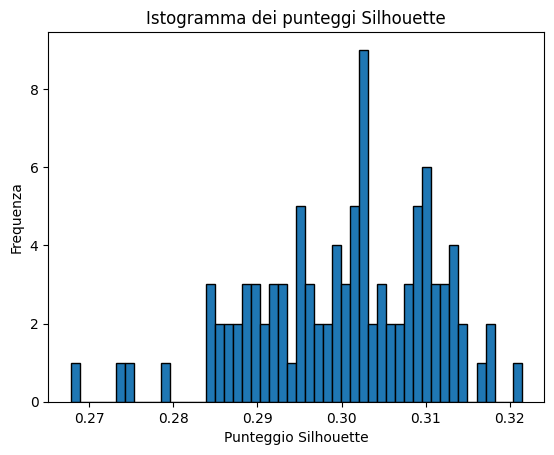

In [13]:
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

def stabilty_analysis(number_sample: int = 100, best_X = best_X, n_clusters = 2, linkage = 'average') -> None:
    """
    Best_X: dataset da cui eseguire il clustering
    """

    silhouette_scores = []
    min_values = np.min(best_X, axis=0)
    max_values = np.max(best_X, axis=0)

    # Esegui il clustering gerarchico 100 volte su dati generati casualmente nel rage di Best_X
    for _ in range(number_sample):
        # Genera dati casuali nel range di X
        X = np.random.uniform(low=min_values, high=max_values, size=best_X.shape)

        # Crea un modello di clustering gerarchico
        model = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage="average").fit(X)
        score = silhouette_score(X, model.labels_)
        silhouette_scores.append(score)
        
    return silhouette_scores


silhouette_scores = stabilty_analysis()
# Crea un istogramma dei punteggi Silhouette
plt.hist(silhouette_scores, bins=50, edgecolor='black')
plt.title('Istogramma dei punteggi Silhouette')
plt.xlabel('Punteggio Silhouette')
plt.ylabel('Frequenza')
plt.show()

# interpretazione risultati
Dai vari plot si può osservare che il clustering divide gli incidenti in baso al fatto che ci siano solo bambini coinvolti

In [14]:
def get_labaled_df():
    best_method = 'complete'
    best_num_clusters = 2
    best_df = df_list[4-1]


    X = scaler.fit_transform(df4.values)
    resultClustering = AgglomerativeClustering(n_clusters=best_num_clusters, metric='euclidean', linkage=best_method).fit_predict(X)

    df = get_prepared_dataset()
    df = df[df['id'].isin(best_df.index)]
    df.reset_index(inplace=True, drop=True)
    df['cluster'] = resultClustering
    
    return df

df = get_labaled_df()

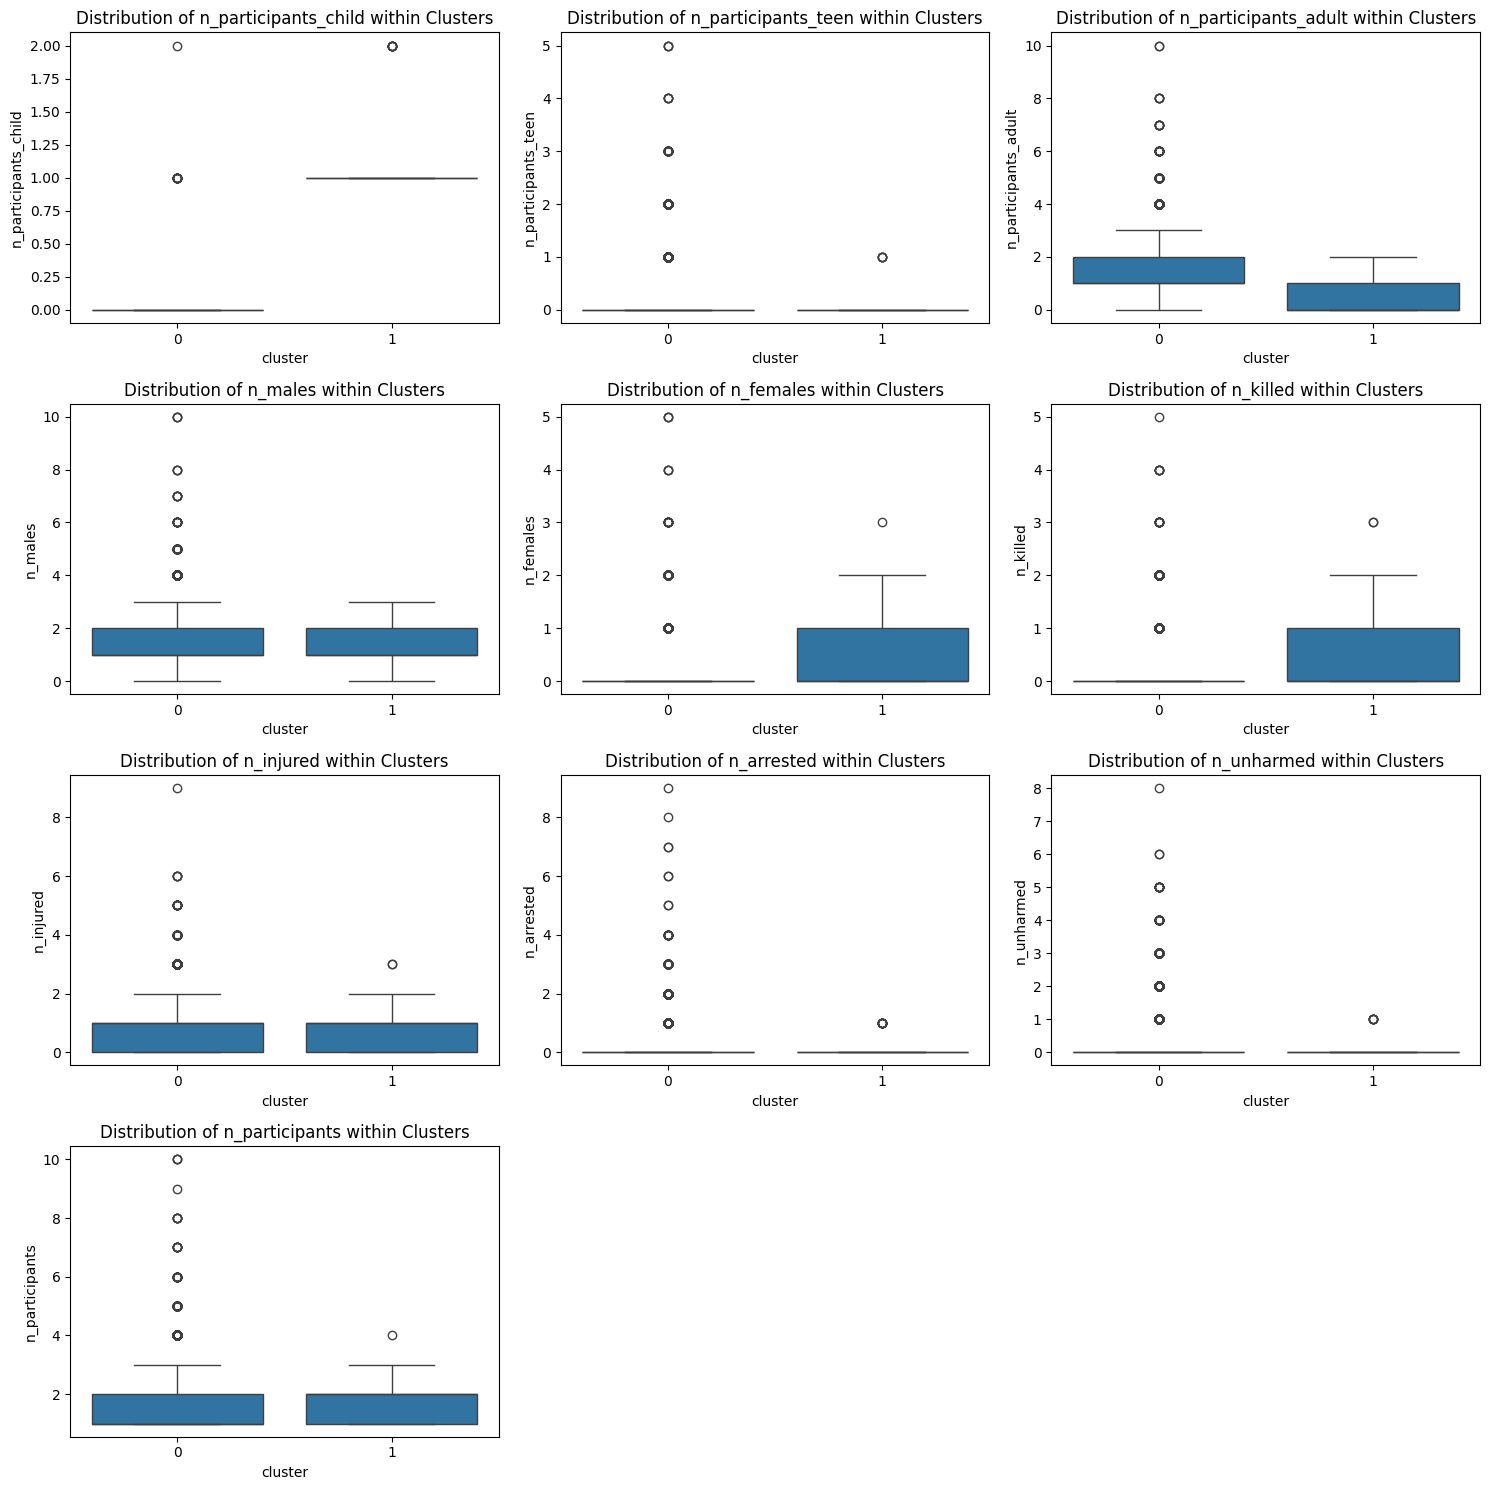

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

attribute = ['n_participants_child', 'n_participants_teen',
            'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
            'n_arrested', 'n_unharmed', 'n_participants', 'cluster']

data = df[attribute]

# Calcola il numero di righe e colonne necessarie per la griglia di grafici
n = len(data.columns) - 1
ncols = int(n**0.5)
nrows = ncols if ncols**2 == n else ncols + 1

# Crea una figura e degli assi
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

# Disegna un grafico per ogni variabile
for ax, variable in zip(axs.flatten(), data.columns[:-1]):
    sns.boxplot(x='cluster', y=variable, data=data, ax=ax)
    ax.set_title(f'Distribution of {variable} within Clusters')

# Rimuovi gli assi vuoti
for ax in axs.flatten()[n:]:
    ax.remove()

plt.tight_layout()
plt.show()


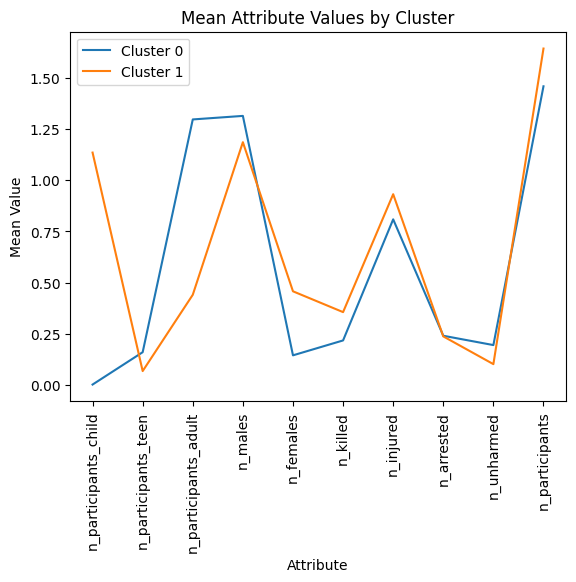

In [16]:
import matplotlib.pyplot as plt

# Calcola la media di ciascun attributo per cluster
means = df[attribute].groupby('cluster').mean()

# Crea un grafico a linee per ciascun cluster
for cluster in means.index:
    plt.plot(means.columns, means.loc[cluster], label=f'Cluster {cluster}')

plt.xlabel('Attribute')
plt.ylabel('Mean Value')
plt.title('Mean Attribute Values by Cluster')
plt.legend()
plt.xticks(rotation=90)  # Ruota le etichette dell'asse x per una migliore leggibilità
plt.show()
